# Выпускная квалификационная работа по курсу «Data Science» на тему: Прогнозирование конечных свойств новых материалов (композиционных материалов)

Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т.е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента).


На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. Кейс основан на реальных производственных задачах Центра НТИ «Цифровое материаловедение: новые материалы и вещества» (структурное подразделение МГТУ им. Н.Э. Баумана).

**План работы**

* Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
* Провести предобработку данных (удаление шумов, нормализация и т.д.).
* Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
* Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 
* Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз.
* Оценить точность модели на тренировочном и тестовом датасете. 
* Создать репозиторий в GitHub и разместить там код исследования. Оформить файл README.

**Описание данных**

Имеется датасет со свойствами композита. Рассматривается базальтопластик с нашивками из углепластика.
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.).
На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов.
Датасет состоит из двух файлов - X_bp (составляющая из базальтопластика) и Х_nup (составляющая из углепластика). Дано, что объединение делать по индексу тип объединения INNER.

# Предобработка данных

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 557.5 MB 4.8 kB/s 
     |████████████████████████████████| 5.7 MB 32.9 MB/s 
     |████████████████████████████████| 1.7 MB 53.4 MB/s 
     |████████████████████████████████| 439 kB 60.6 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [4]:
# Импорт библиотек
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from catboost import CatBoostRegressor, Pool
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import (GridSearchCV, TimeSeriesSplit,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras

In [5]:
RANDOM_STATE = 12345

In [96]:
# Подключаем доступ к файлам данных для гугл драйв
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [97]:
# Пути для гугл драйв
datasets_path = '/content/drive/MyDrive/Colab Notebooks/datasets/'
models_path = '/content/drive/MyDrive/Colab Notebooks/models/'

In [8]:
# Пути для локального запуска
#datasets_path = '../datasets/'
#models_path = '../application/models/'

In [9]:
# Чтение файлов с данными и их сохранение
x_bp = pd.read_excel(datasets_path + 'X_bp.xlsx', index_col=0)
x_nup = pd.read_excel(datasets_path + 'X_nup.xlsx', index_col=0)

# Получение информации о датафреймах
for data in (x_bp, x_nup):
    display(data.head())
    print('\n\n')
    display(data.info())
    print('\n\n')
    display(data.describe())

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   
2.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   
4.0                         2.771331            2030.0             753.000000   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0.0                        30.00                        22.267857   
1.0                        50.00                        23.750000   
2.0                        49.90                        33.000000   
3.0                       129.00                        21.250000   
4.0                       111.86                        22.267857   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   
2.0                284.615385                          210.0   
3.0                300.000000                          210.0   
4.0                284.615385                          210.0   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   
2.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   
4.0                                  70.0                         3000.0   

     Потребление смолы, г/м2  
0.0                    220.0  
1.0                    220.0  
2.0                    220.0  
3.0                    220.0  
4.0                    220.0




<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


None

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  
count                    1023.000000              1023.000000  
mean                     2466.922843               218.423144  
std                       485.628006                59.735931  
min                      1036.856605                33.803026  
25%                      2135.850448               179.627520  
50%                      2459.524526               219.198882  
75%                      2767.193119               257.481724  
max                      3848.436732               414.590628

Угол нашивки, град  Шаг нашивки  Плотность нашивки
0.0                 0.0          4.0               57.0
1.0                 0.0          4.0               60.0
2.0                 0.0          4.0               70.0
3.0                 0.0          5.0               47.0
4.0                 0.0          5.0               57.0




<class 'pandas.core.frame.DataFrame'>
Float64Index: 1040 entries, 0.0 to 1039.0
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Угол нашивки, град  1040 non-null   float64
 1   Шаг нашивки         1040 non-null   float64
 2   Плотность нашивки   1040 non-null   float64
dtypes: float64(3)
memory usage: 32.5 KB


None

Угол нашивки, град  Шаг нашивки  Плотность нашивки
count          1040.00000  1040.000000        1040.000000
mean             45.00000     6.911385          57.248399
std              45.02165     2.555181          12.332438
min               0.00000     0.000000           0.000000
25%               0.00000     5.102256          49.970740
50%              45.00000     6.938000          57.413594
75%              90.00000     8.587662          65.107235
max              90.00000    14.440522         103.988901

Проведя первый осмотр данных, мы видим, что типы данных в обоих датасетах - float64, пропусков нет. Однако количество строк в таблицах не одинаково - 1023 в x_bp и 1040 в x_nup.

Объеденяем таблицы по индексу, тип объединения INNER. При этом мы потеряем 17 строк из таблицы x_nup.

In [10]:
# объединяем датасеты
data = x_bp.join(x_nup, how='inner')
data.shape

(1023, 13)

Проведем предобработку данных. Проверим данные на наличие явных дубликатов.

In [11]:
data.duplicated().sum()

0

Дубликаты не обнаружены. 


Посмотрим на диаграммы рассения и тепловую карту.

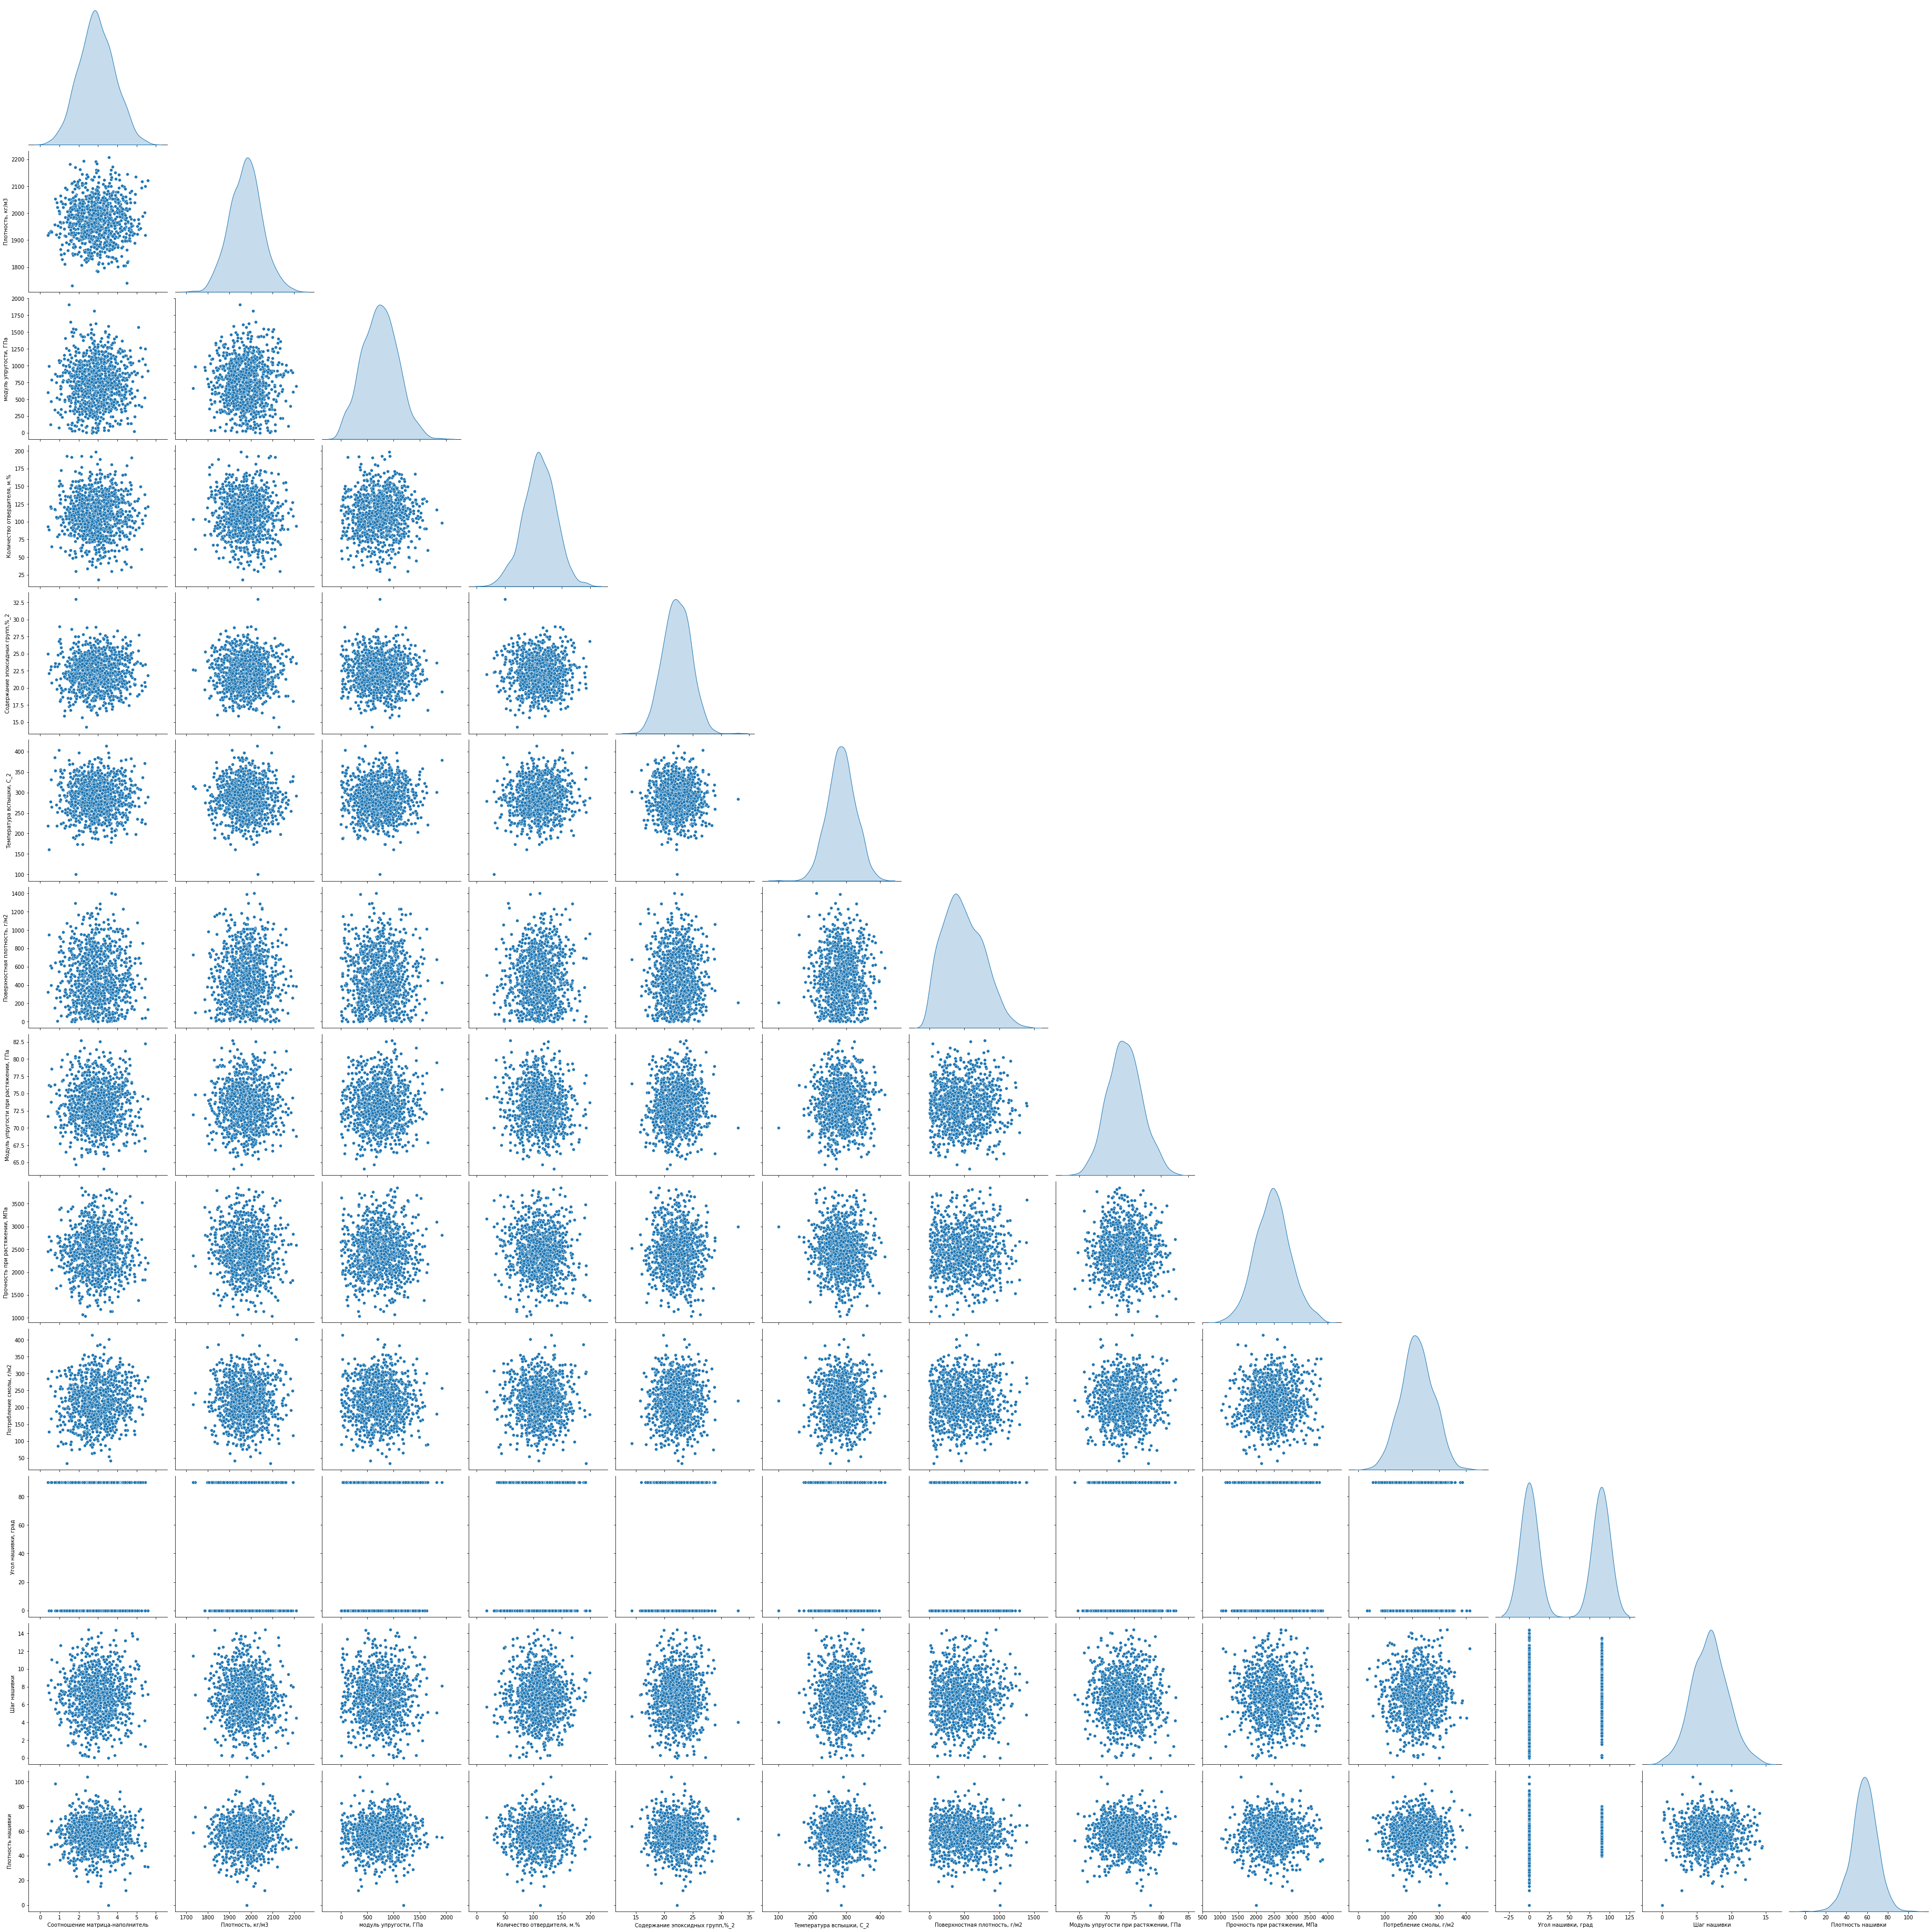

In [12]:
# Строим попарные диаграммы рассеяния
sns.pairplot(data, height=4, diag_kind='kde', corner = True);

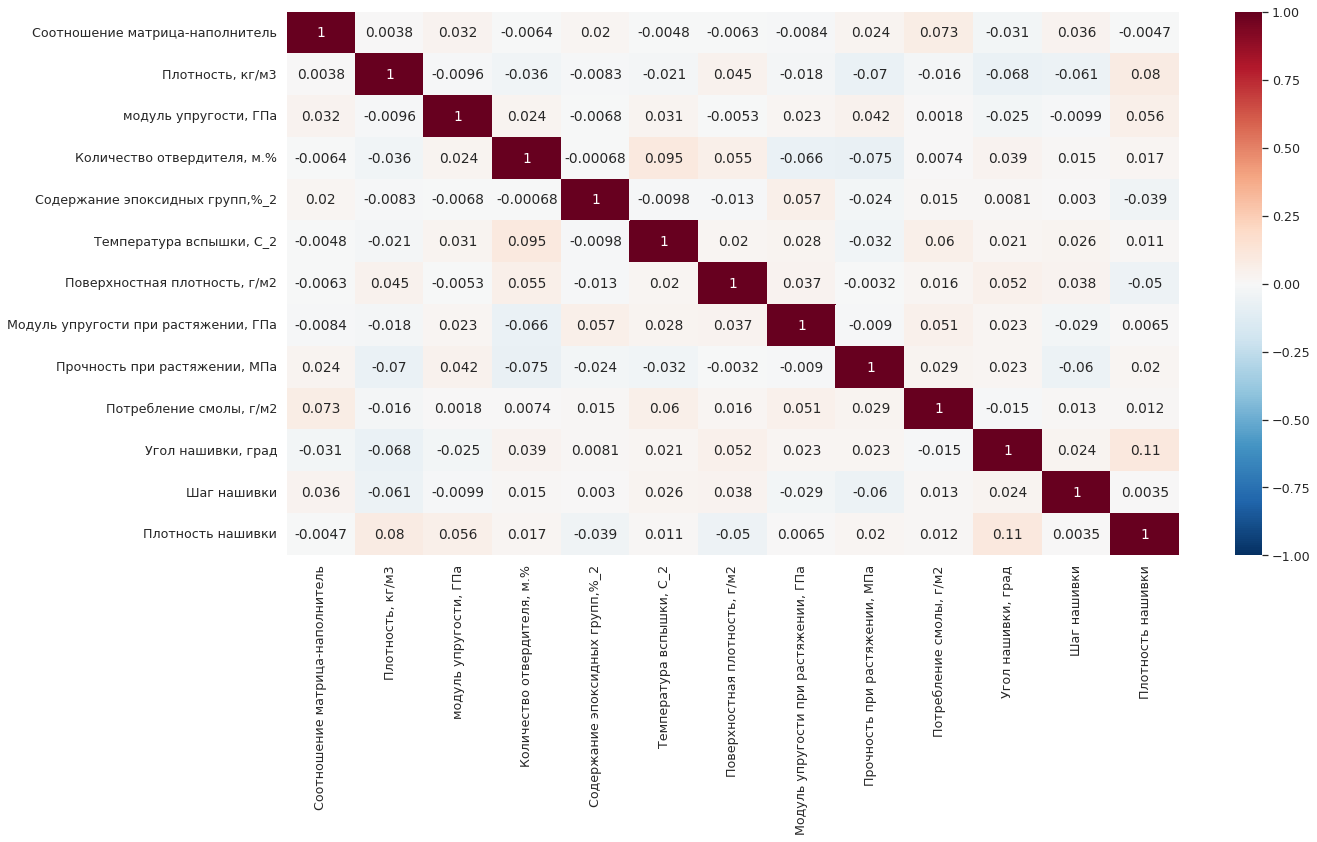

In [13]:
sns.set(font_scale=1.15)
plt.figure(figsize=(20, 10))
sns.heatmap(
    data.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1); 

Изучая данные графики, мы можем сказать, что линейная корреляция для признаков не обнаружена. Коэффициенты корреляции на тепловой карте, близкие к 0, показывают отсутствие линейной зависимости между признаками,  возможно, зависимость между признаками присутствует, но она более сложная.


Посмотрим на распределения данных в нашем датасете. Для этого построим гистограммы и боксплоты.

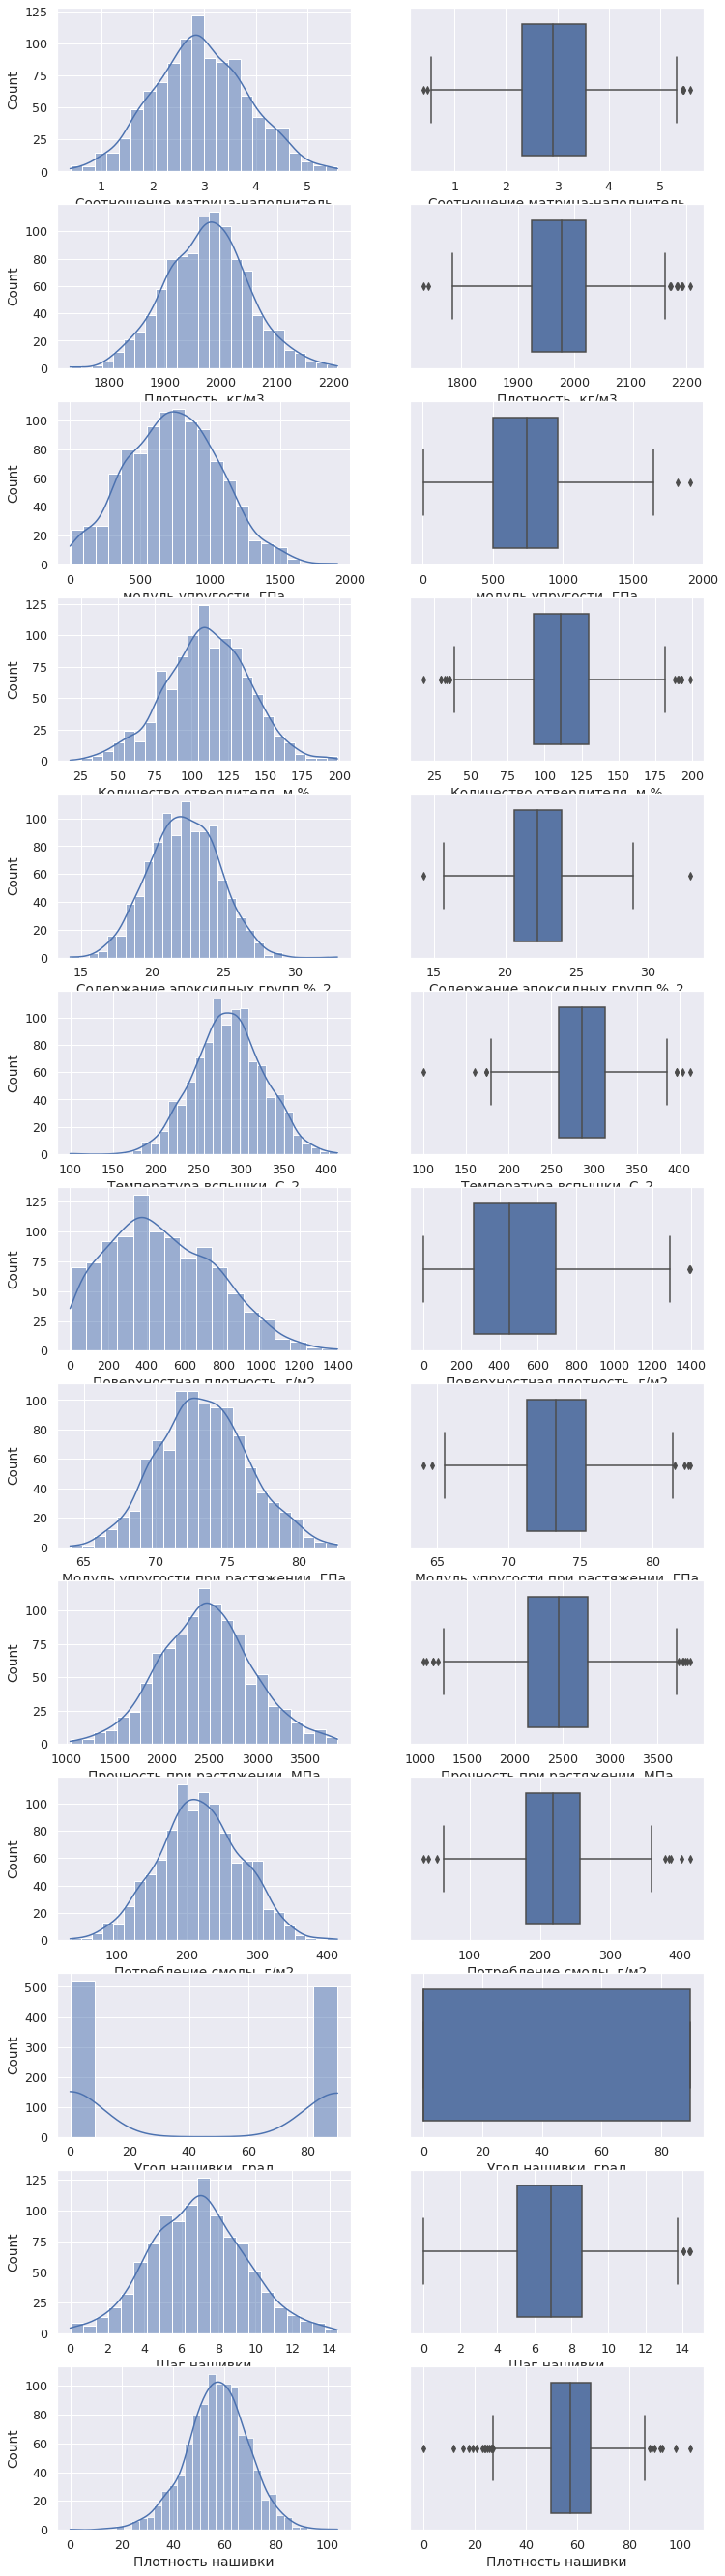

In [14]:
# строим графики распределения переменных и боксплоты
fig, axes = plt.subplots(13, 2, figsize=(12, 48))
for k, column in enumerate(data.columns):    
    sns.histplot(data=data, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=data, x=column, ax=axes[k, 1])
plt.show()

Анализируя полученные графики, можем сказать, что признаки (исключая  "Угол нашивки") имеют нормальное распределение и принимают неотрицательные значения.
Признак "Угол нашивки" принимает 2 значения - 0 и 90. Можем превобразовать признак в бинарный на этапе кодирования данных.

Боксплоты показывают нам на наличие выбросов в данных. Обработаем эти выбросы.

Мы выяснили, что распределения признаков близко к нормальному. Поэтому для обработки выбросов данных воспользуемся правилом трех сигм.

In [15]:
outliers = pd.DataFrame(index=data.index)
for column in data:
    zscore = (data[column] - data[column].mean()) / data[column].std()
    outliers[column] = (zscore.abs() > 3)
data = data[outliers.sum(axis=1)==0]
data.shape


(1000, 13)

Оценим данные после удаления выбросов

In [93]:
data.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1000.000000       1000.000000   
mean                          2.936299       1975.402478   
std                           0.908779         72.953703   
min                           0.389403       1784.482245   
25%                           2.319283       1923.628661   
50%                           2.908811       1977.321002   
75%                           3.553931       2021.159498   
max                           5.591742       2192.738783   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1000.000000                  1000.000000   
mean              738.675486                   110.821904   
std               327.545245                    27.869622   
min                 2.436909                    29.956150   
25%               500.772963                    92.523816   
50%               741.148111                   110.652620   
75%               961.650808                   129.853101   
max              1649.415706                   192.851702   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1000.000000               1000.000000   
mean                         22.235549                285.957299   
std                           2.384246                 40.231508   
min                          15.695894                173.484920   
25%                          20.583191                259.103839   
50%                          22.221462                285.853960   
75%                          23.974880                313.029126   
max                          28.955094                403.652861   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1000.000000                           1000.000000   
mean                      479.855825                             73.318178   
std                       277.708571                              3.113817   
min                         0.603740                             64.054061   
25%                       266.978731                             71.248823   
50%                       450.869535                             73.230375   
75%                       691.528426                             75.326573   
max                      1291.340115                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1000.000000              1000.000000   
mean                     2464.864198               218.254011   
std                       485.015353                58.944958   
min                      1036.856605                41.048278   
25%                      2134.535871               179.812213   
50%                      2456.394188               218.697660   
75%                      2760.163022               257.474775   
max                      3848.436732               386.903431   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1000.000000  1000.000000        1000.000000  
mean            44.640000     6.910600          57.276293  
std             45.021076     2.557748          11.845791  
min              0.000000     0.037639          20.571633  
25%              0.000000     5.105814          49.892983  
50%              0.000000     6.922196          57.471971  
75%             90.000000     8.588839          64.930896  
max             90.000000    14.440522          92.963492

Оценка плотности ядра

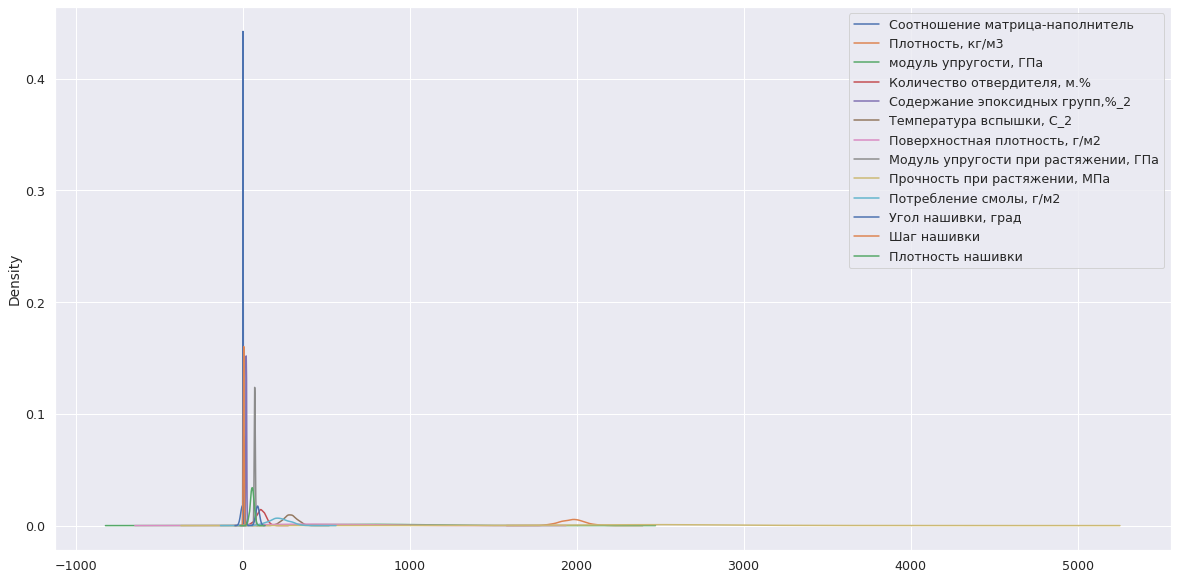

In [17]:
def plt_kde(data):
  fig, ax = plt.subplots(figsize=(20, 10))
  data.plot(kind='kde', ax=ax)
plt_kde(data)

## Выводы:

В данном разделе мы выполнили следующие шаги:
1. Загрузили и изучили данные
2. Выявили отсутствие пропусков 
3. Построили графики и диаграммы: графики рассеяния, тепловая карта, гистограммы распределения каждого признака, боксплоты и оценили плотность ядра
4. Очистили данные от выбросов и аномалий, используя метод трех сигм

Выполняя данные шаги мы пришли к следующим выводам: 
1. Линейная корреляция признаков не обнаружена
2. Признаки (исключая "Угол нашивки") имеют нормальное распределение и принимают неотрицательные значения
3. Признак "Угол нашивки" принимает 2 значения - 0 и 90

Приступим к обучению моделей и подбору их гиперпараметров.

# Разработка и обучение модели

### Модели для "Модуля упругости при растяжении, ГПа" и "Прочности при растяжении, МПа"

Будем оценивать несколько моделей:



1.   DummyRegressor
2.   LinearRegression
3.   Ridge
4.   Lasso
5.   SVR
6.   KNeighborsRegressor
7.   DecisionTreeRegressor
8.   RandomForestRegressor
9.   CatBoostRegressor
10.  LGBMRegressor
11.  GradientBoostingRegressor



In [18]:
# Выделяем целевые признаки
features = data.drop(['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'], axis=1)
target_1 = data['Модуль упругости при растяжении, ГПа']

target_2 = data['Прочность при растяжении, МПа']

In [19]:
# Разделяем данные на тренировочную и тестовую выборку
features_train, features_test, target_train_1, target_test_1 = train_test_split(features, target_1, test_size=0.3, random_state=RANDOM_STATE)
display(features_train.shape)
display(target_train_1.shape)
target_test_1.reset_index(drop=True, inplace=True)

features_train, features_test, target_train_2, target_test_2 = train_test_split(features, target_2, test_size=0.3, random_state=RANDOM_STATE)
display(features_train.shape)
display(target_train_2.shape)
target_test_2.reset_index(drop=True, inplace=True)

(700, 11)

(700,)

(700, 11)

(700,)

In [20]:
# Функция для оценки предсказаний моделей
def get_metrics(model_name, target, predictions):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(target, predictions)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(target, predictions, squared=False)
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(target, predictions)
    stat.loc[model_name, 'MAPE'] = metrics.mean_absolute_percentage_error(target, predictions)
    stat.loc[model_name, 'max_error'] = metrics.max_error(target, predictions)
    return stat

In [21]:
# Базовая модель
dummy_regressor_1 = DummyRegressor(strategy="mean")
dummy_regressor_1.fit(features_train, target_train_1)
dummy_predictions_train_1 = dummy_regressor_1.predict(features_train)
dummy_predictions_test_1 = dummy_regressor_1.predict(features_test)
results_train_1 = get_metrics('DummyRegressor', target_train_1, dummy_predictions_train_1)
results_test_1 = get_metrics('DummyRegressor', target_test_1, dummy_predictions_test_1)

dummy_regressor_2 = DummyRegressor(strategy="mean")
dummy_regressor_2.fit(features_train, target_train_2)
dummy_predictions_train_2 = dummy_regressor_2.predict(features_train)
dummy_predictions_test_2 = dummy_regressor_2.predict(features_test)
results_train_2 = get_metrics('DummyRegressor', target_train_2, dummy_predictions_train_2)
results_test_2 = get_metrics('DummyRegressor', target_test_2, dummy_predictions_test_2)

In [22]:
# LinearRegression
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('lr', LinearRegression()),
    ]
)

parametrs = [
    {'lr__copy_X': [True, False]}
]

linear_regression_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
linear_regression_1.fit(features_train, target_train_1) 
display(linear_regression_1.best_params_)
display(linear_regression_1.best_score_)

linear_regression_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
linear_regression_2.fit(features_train, target_train_2) 
display(linear_regression_2.best_params_)
display(linear_regression_2.best_score_)

{'lr__copy_X': True}

-0.006398449783340898

{'lr__copy_X': True}

-0.028583922692652586

In [23]:
lr_predictions_1 = linear_regression_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('LinearRegression', target_train_1, lr_predictions_1))
lr_predictions_1 = linear_regression_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('LinearRegression', target_test_1, lr_predictions_1))

lr_predictions_2 = linear_regression_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('LinearRegression', target_train_2, lr_predictions_2))
lr_predictions_2 = linear_regression_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('LinearRegression', target_test_2, lr_predictions_2))

In [24]:
# Ridge
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('ridge', Ridge()),
    ]
)

parametrs = [
    {
        'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
        'ridge__alpha': range(10, 1510, 10)
        },
    {
        'ridge__solver': ['lbfgs'],
        'ridge__alpha': range(10, 1510, 10),
        'ridge__positive': [True]
        }
]

ridge_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
ridge_1.fit(features_train, target_train_1) 
display(ridge_1.best_params_)
display(ridge_1.best_score_)

ridge_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
ridge_2.fit(features_train, target_train_2) 
display(ridge_2.best_params_)
display(ridge_2.best_score_)

{'ridge__alpha': 20, 'ridge__solver': 'sparse_cg'}

0.001370969869390204

{'ridge__alpha': 20, 'ridge__solver': 'sparse_cg'}

-0.020241039611515355

In [25]:
ridge_predictions_1 = ridge_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('Ridge', target_train_1, ridge_predictions_1))
ridge_predictions_1 = ridge_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('Ridge', target_test_1, ridge_predictions_1))

ridge_predictions_2 = ridge_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('Ridge', target_train_2, ridge_predictions_2))
ridge_predictions_2 = ridge_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('Ridge', target_test_2, ridge_predictions_2))

In [26]:
# Lasso
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('lasso', Lasso()),
    ]
)

parametrs = [
    {
        'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.095, 0.1, 0.150, 0.2, 0.5, 1], 
    } 
]

lasso_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
lasso_1.fit(features_train, target_train_1) 
display(lasso_1.best_params_)
display(lasso_1.best_score_)

lasso_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
lasso_2.fit(features_train, target_train_2) 
display(lasso_2.best_params_)
display(lasso_2.best_score_)

{'lasso__alpha': 0.01}

-0.0022876368664337954

{'lasso__alpha': 1}

-0.02541837743409293

In [27]:
lasso_predictions_1 = lasso_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('Lasso', target_train_1, lasso_predictions_1))
lasso_predictions_1 = lasso_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('Lasso', target_test_1, lasso_predictions_1))

lasso_predictions_2 = lasso_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('Lasso', target_train_2, lasso_predictions_2))
lasso_predictions_2 = lasso_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('Lasso', target_test_2, lasso_predictions_2))

In [28]:
# SVR
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('svr', SVR()),
    ]
)

parametrs = [
    {
      'svr__kernel': ['linear'],
      'svr__C': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
    },
    {
      'svr__kernel': ['poly'],
      'svr__C': [0.001, 0.01, 0.02]
    },
    {
      'svr__kernel': ['rbf'],
      'svr__C': [0.01, 0.02, 0.03, 0.04]
    },
    {
      'svr__kernel': ['sigmoid'],
      'svr__C': [0.01, 0.02, 0.03, 0.04, 0.5]
    }, 
]

svr_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
svr_1.fit(features_train, target_train_1) 
display(svr_1.best_params_)
display(svr_1.best_score_)


svr_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
svr_2.fit(features_train, target_train_2) 
display(svr_2.best_params_)
display(svr_2.best_score_)

{'svr__C': 0.04, 'svr__kernel': 'rbf'}

-0.001199230039367638

{'svr__C': 0.02, 'svr__kernel': 'poly'}

-0.024098200507591927

In [29]:
svr_predictions_1 = svr_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('SVR', target_train_1, svr_predictions_1))
svr_predictions_1 = svr_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('SVR', target_test_1, svr_predictions_1))

svr_predictions_2 = svr_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('SVR', target_train_2, svr_predictions_2))
svr_predictions_2 = svr_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('SVR', target_test_2, svr_predictions_2))

In [30]:
# KNeighborsRegressor
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('knr', KNeighborsRegressor()),
    ]
)

parametrs = [
    {
      'knr__n_neighbors': range(3, 31, 2)
    } 
]

knr_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
knr_1.fit(features_train, target_train_1) 
display(knr_1.best_params_)
display(knr_1.best_score_)


knr_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
knr_2.fit(features_train, target_train_2) 
display(knr_2.best_params_)
display(knr_2.best_score_)

{'knr__n_neighbors': 27}

0.001985985638557197

{'knr__n_neighbors': 29}

-0.05831962626446389

In [31]:
knr_predictions_1 = knr_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('KNeighborsRegressor', target_train_1, knr_predictions_1))
knr_predictions_1 = knr_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('KNeighborsRegressor', target_test_1, knr_predictions_1))

knr_predictions_2 = knr_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('KNeighborsRegressor', target_train_2, knr_predictions_2))
knr_predictions_2 = knr_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('KNeighborsRegressor', target_test_2, knr_predictions_2))

In [32]:
# DecisionTreeRegressor
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('dtr', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ]
)

parametrs = [
    {
      'dtr__splitter': ['best', 'random'],
      'dtr__max_features': range(1, 11),
      'dtr__max_depth': range(1, 21),
    } 
]

dtr_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
dtr_1.fit(features_train, target_train_1) 
display(dtr_1.best_params_)
display(dtr_1.best_score_)

dtr_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
dtr_2.fit(features_train, target_train_2) 
display(dtr_2.best_params_)
display(dtr_2.best_score_)

{'dtr__max_depth': 1, 'dtr__max_features': 1, 'dtr__splitter': 'best'}

-0.0019789474335736522

{'dtr__max_depth': 3, 'dtr__max_features': 3, 'dtr__splitter': 'random'}

-0.00982333963075216

In [33]:
dtr_predictions_1 = dtr_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('DecisionTreeRegressor', target_train_1, dtr_predictions_1))
dtr_predictions_1 = dtr_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('DecisionTreeRegressor', target_test_1, dtr_predictions_1))

dtr_predictions_2 = dtr_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('DecisionTreeRegressor', target_train_2, dtr_predictions_2))
dtr_predictions_2 = dtr_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('DecisionTreeRegressor', target_test_2, dtr_predictions_2))

In [37]:
# RandomForestRegressor
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('rfr', RandomForestRegressor(random_state=RANDOM_STATE)),
    ]
)

parametrs = [
    {
      'rfr__n_estimators': range(50, 151, 50), 
      'rfr__max_depth': range(1, 11),
      'rfr__max_features': range(1, 11),
    } 
]

rfr_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
rfr_1.fit(features_train, target_train_1) 
display(rfr_1.best_params_)
display(rfr_1.best_score_)


rfr_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
rfr_2.fit(features_train, target_train_2) 
display(rfr_2.best_params_)
display(rfr_2.best_score_)

{'rfr__max_depth': 3, 'rfr__max_features': 1, 'rfr__n_estimators': 150}

0.0007388995487566441

{'rfr__max_depth': 5, 'rfr__max_features': 1, 'rfr__n_estimators': 50}

-0.008666803097363684

In [38]:
rfr_predictions_1 = rfr_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('RandomForestRegressor', target_train_1, rfr_predictions_1))
rfr_predictions_1 = rfr_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('RandomForestRegressor', target_test_1, rfr_predictions_1))


rfr_predictions_2 = rfr_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('RandomForestRegressor', target_train_2, rfr_predictions_2))
rfr_predictions_2 = rfr_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('RandomForestRegressor', target_test_2, rfr_predictions_2))

In [39]:
TimeSeriesSplit(n_splits=10)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [40]:
# CatBoostRegressor
catboost_1 = CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE)
cat_params = {
    'depth': [5, 10], 
    'learning_rate': np.arange(0.1, 1, 0.2),
    }
catboost_grid_1 = catboost_1.grid_search(cat_params, Pool(features_train, target_train_1), cv=TimeSeriesSplit(n_splits=10), verbose=True)

catboost_2 = CatBoostRegressor(loss_function='RMSE', random_state=RANDOM_STATE)
catboost_grid_2 = catboost_2.grid_search(cat_params, Pool(features_train, target_train_2), cv=TimeSeriesSplit(n_splits=10), verbose=True)

Выходные данные были обрезаны до нескольких последних строк (5000).
24:	learn: 335.1512634	test: 589.6962723	best: 584.1996679 (21)	total: 54.3ms	remaining: 2.12s
25:	learn: 330.4389952	test: 593.0773556	best: 584.1996679 (21)	total: 56.4ms	remaining: 2.11s
26:	learn: 324.4258389	test: 596.0711258	best: 584.1996679 (21)	total: 58.5ms	remaining: 2.11s
27:	learn: 322.5805159	test: 596.9011847	best: 584.1996679 (21)	total: 60.7ms	remaining: 2.11s
28:	learn: 313.5599672	test: 602.7886875	best: 584.1996679 (21)	total: 62.8ms	remaining: 2.1s
29:	learn: 311.0223415	test: 603.1284317	best: 584.1996679 (21)	total: 64.9ms	remaining: 2.1s
30:	learn: 305.4939098	test: 604.1111073	best: 584.1996679 (21)	total: 67.2ms	remaining: 2.1s
31:	learn: 302.8161377	test: 605.8516787	best: 584.1996679 (21)	total: 69.3ms	remaining: 2.1s
32:	learn: 299.8477256	test: 603.0621893	best: 584.1996679 (21)	total: 71.5ms	remaining: 2.1s
33:	learn: 297.8693532	test: 602.4102260	best: 584.1996679 (21)	total: 73.9ms	rema

In [41]:
display(catboost_grid_1['params'])
display(catboost_grid_2['params'])

{'depth': 5, 'learning_rate': 0.1}

{'depth': 5, 'learning_rate': 0.30000000000000004}

In [42]:
catboost_final_1 = CatBoostRegressor(depth=catboost_grid_1['params']['depth'], 
                                   learning_rate=catboost_grid_1['params']['learning_rate'],
                                   loss_function='RMSE', verbose=100)
catboost_final_1.fit(Pool(features_train, target_train_1))

catboost_final_2 = CatBoostRegressor(depth=catboost_grid_2['params']['depth'], 
                                   learning_rate=catboost_grid_2['params']['learning_rate'],
                                   loss_function='RMSE', verbose=100)
catboost_final_2.fit(Pool(features_train, target_train_2))

0:	learn: 3.1281483	total: 3.72ms	remaining: 3.71s
100:	learn: 2.3223938	total: 215ms	remaining: 1.91s
200:	learn: 1.8106342	total: 398ms	remaining: 1.58s
300:	learn: 1.4415740	total: 597ms	remaining: 1.39s
400:	learn: 1.1387092	total: 784ms	remaining: 1.17s
500:	learn: 0.9021265	total: 967ms	remaining: 963ms
600:	learn: 0.7107265	total: 1.18s	remaining: 785ms
700:	learn: 0.5587295	total: 1.38s	remaining: 590ms
800:	learn: 0.4531146	total: 1.58s	remaining: 393ms
900:	learn: 0.3670283	total: 1.77s	remaining: 195ms
999:	learn: 0.3015427	total: 1.97s	remaining: 0us
0:	learn: 478.8548884	total: 2.05ms	remaining: 2.05s
100:	learn: 206.4898690	total: 213ms	remaining: 1.9s
200:	learn: 100.9753368	total: 404ms	remaining: 1.6s
300:	learn: 55.1558264	total: 600ms	remaining: 1.39s
400:	learn: 30.0493656	total: 788ms	remaining: 1.18s
500:	learn: 16.7987743	total: 970ms	remaining: 966ms
600:	learn: 9.2118358	total: 1.18s	remaining: 785ms
700:	learn: 5.0015592	total: 1.37s	remaining: 586ms
800:	lear

In [43]:
catboost_predictions_1 = catboost_final_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('CatBoostRegressor', target_train_1, catboost_predictions_1))
catboost_predictions_1 = catboost_final_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('CatBoostRegressor', target_test_1, catboost_predictions_1))

catboost_predictions_2 = catboost_final_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('CatBoostRegressor', target_train_2, catboost_predictions_2))
catboost_predictions_2 = catboost_final_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('CatBoostRegressor', target_test_2, catboost_predictions_2))

In [44]:
# LGBMRegressor
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('lgbm', lgb.LGBMRegressor()),
    ]
)

parametrs = [
    {
        'lgbm__num_leaves':[31, 100, 200], 
        'lgbm__learning_rate':[0.1, 0.3, 0.5],
    }
]

lgbm_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
lgbm_1.fit(features_train, target_train_1) 
display(lgbm_1.best_params_)
display(lgbm_1.best_score_)

lgbm_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
lgbm_2.fit(features_train, target_train_2) 
display(lgbm_2.best_params_)
display(lgbm_2.best_score_)

{'lgbm__learning_rate': 0.1, 'lgbm__num_leaves': 31}

-0.2459215598494759

{'lgbm__learning_rate': 0.1, 'lgbm__num_leaves': 31}

-0.1740229886470541

In [45]:
lgbm_predictions_1 = lgbm_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('LGBMRegressor', target_train_1, lgbm_predictions_1))
lgbm_predictions_1 = lgbm_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('LGBMRegressor', target_test_1, lgbm_predictions_1))

lgbm_predictions_2 = lgbm_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('LGBMRegressor', target_train_2, lgbm_predictions_2))
lgbm_predictions_2 = lgbm_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('LGBMRegressor', target_test_2, lgbm_predictions_2))

In [46]:
# GradientBoostingRegressor
pipeline = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('gbr', GradientBoostingRegressor(random_state=RANDOM_STATE)),
    ]
)

parametrs = [
    {
        'gbr__loss': ['squared_error', 'absolute_error'], 
        'gbr__n_estimators': [50, 100, 150],
        'gbr__max_depth': [1, 2, 3],
        'gbr__max_features': [1, 2, 5, 11],
    }
]

gbr_1 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
gbr_1.fit(features_train, target_train_1) 
display(gbr_1.best_params_)
display(gbr_1.best_score_)

gbr_2 = GridSearchCV(
    estimator=pipeline, 
    param_grid=parametrs, 
    cv=10, 
    scoring='r2',  
    n_jobs=-1
)
gbr_2.fit(features_train, target_train_2) 
display(gbr_2.best_params_)
display(gbr_2.best_score_)

{'gbr__loss': 'absolute_error',
 'gbr__max_depth': 1,
 'gbr__max_features': 2,
 'gbr__n_estimators': 50}

-0.007620034591826907

{'gbr__loss': 'squared_error',
 'gbr__max_depth': 2,
 'gbr__max_features': 1,
 'gbr__n_estimators': 50}

-0.010203852596382457

In [48]:
gbr_predictions_1 = gbr_1.predict(features_train)
results_train_1 = results_train_1.append(get_metrics('GradientBoostingRegressor', target_train_1, gbr_predictions_1))
gbr_predictions_1 = gbr_1.predict(features_test)
results_test_1 = results_test_1.append(get_metrics('GradientBoostingRegressor', target_test_1, gbr_predictions_1))

gbr_predictions_2 = gbr_2.predict(features_train)
results_train_2 = results_train_2.append(get_metrics('GradientBoostingRegressor', target_train_2, gbr_predictions_2))
gbr_predictions_2 = gbr_2.predict(features_test)
results_test_2 = results_test_2.append(get_metrics('GradientBoostingRegressor', target_test_2, gbr_predictions_2))

Выведем и проанализируем результаты работы моделей для предсказания двух признаков на тренирововчной и тестовых выборках.

In [103]:
display(results_test_1)

R2      RMSE       MAE      MAPE  max_error
DummyRegressor            -0.000637  3.037614  2.451541  0.033474   9.184598
LinearRegression          -0.027256  3.077751  2.490270  0.034001   8.696302
Ridge                     -0.008641  3.049738  2.462914  0.033627   8.950818
Lasso                     -0.013971  3.057785  2.470518  0.033731   8.845795
SVR                       -0.003542  3.042020  2.453717  0.033486   9.134810
KNeighborsRegressor       -0.043995  3.102726  2.514148  0.034338   8.648469
DecisionTreeRegressor     -0.007256  3.047643  2.468863  0.033730   9.141288
RandomForestRegressor     -0.002240  3.040045  2.450632  0.033464   9.021327
RandomForestRegressor     -0.002240  3.040045  2.450632  0.033464   9.021327
CatBoostRegressor         -0.153545  3.261455  2.575692  0.035115  10.221554
LGBMRegressor             -0.131812  3.230586  2.588977  0.035375   9.272518
GradientBoostingRegressor -0.010664  3.052795  2.471146  0.033743   9.001461

In [104]:
display(results_test_2)

R2        RMSE         MAE      MAPE  \
DummyRegressor            -0.000126  486.661114  377.888006  0.169870   
LinearRegression          -0.034072  494.851306  390.849482  0.173599   
Ridge                     -0.013243  489.842094  384.184501  0.171572   
Lasso                     -0.025234  492.732135  388.599744  0.172956   
SVR                       -0.000684  486.796951  378.563890  0.169446   
KNeighborsRegressor       -0.023321  492.272110  386.349169  0.172472   
DecisionTreeRegressor     -0.022080  491.973684  381.454292  0.171453   
RandomForestRegressor     -0.006850  488.294456  381.044142  0.170590   
CatBoostRegressor         -0.211601  535.647683  422.471777  0.187321   
LGBMRegressor             -0.201972  533.514941  424.111028  0.188525   
GradientBoostingRegressor -0.016042  490.518418  384.057211  0.171454   

                             max_error  
DummyRegressor             1429.643384  
LinearRegression           1400.304664  
Ridge                      1400.675910  
Lasso                      1386.105483  
SVR                        1417.964939  
KNeighborsRegressor        1462.048774  
DecisionTreeRegressor      1410.035042  
RandomForestRegressor      1446.797333  
CatBoostRegressor          1626.489884  
LGBMRegressor              1638.869758  
GradientBoostingRegressor  1410.593198

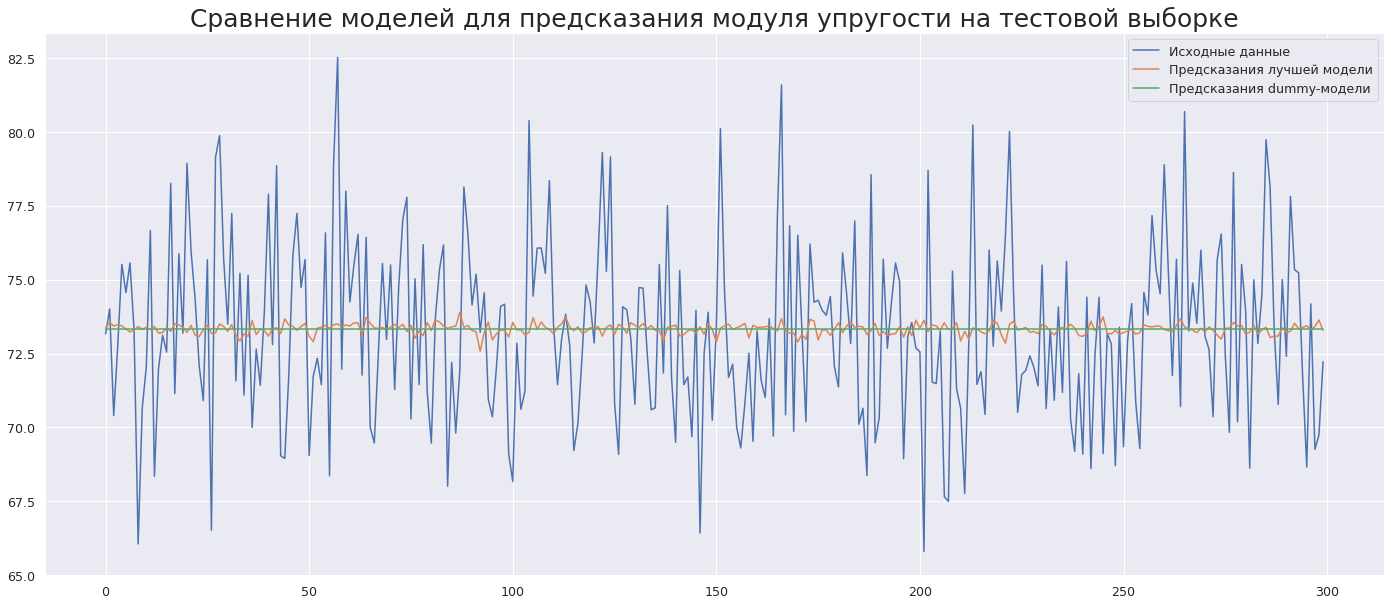

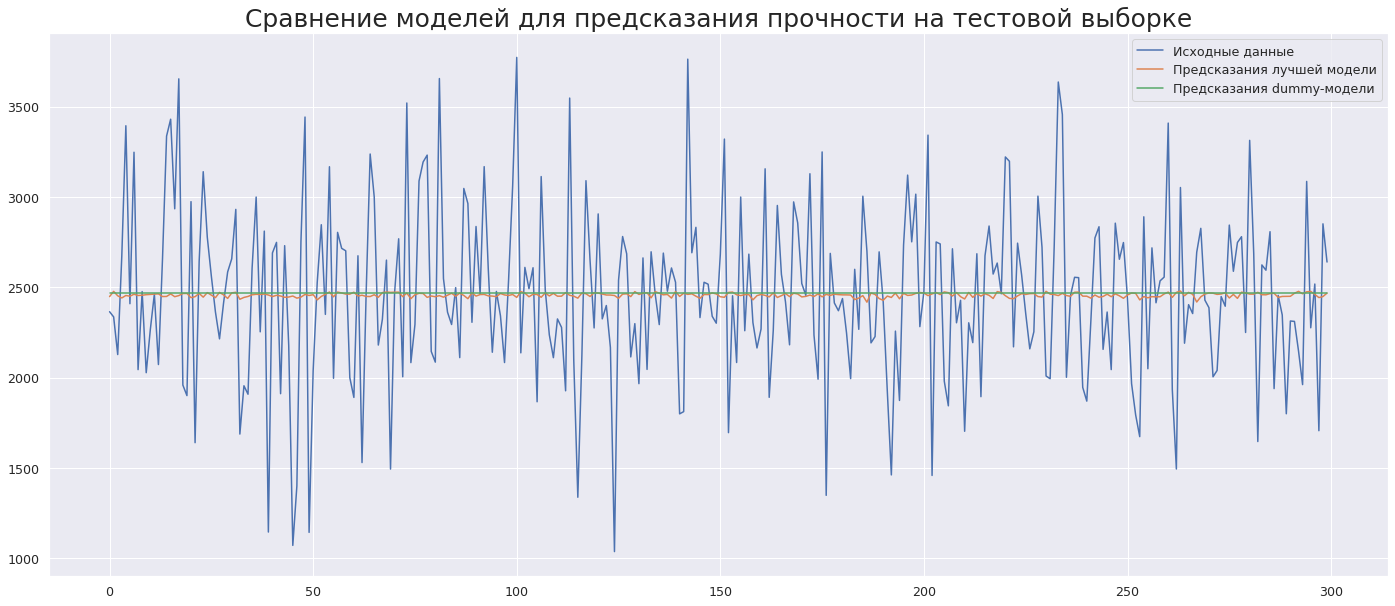

In [100]:
# Визуализация
fig, ax = plt.subplots(figsize=(24, 10))
ax.plot(target_test_1, label='Исходные данные')
ax.plot(rfr_predictions_1, label='Предсказания лучшей модели')
ax.plot(dummy_predictions_test_1, label='Предсказания dummy-модели')
ax.legend()
plt.title('Сравнение моделей для предсказания модуля упругости на тестовой выборке', fontsize=25)
plt.show()

fig, ax = plt.subplots(figsize=(24, 10))
ax.plot(target_test_2, label='Исходные данные')
ax.plot(svr_predictions_2, label='Предсказания лучшей модели')
ax.plot(dummy_predictions_test_2, label='Предсказания dummy-модели')
ax.legend()
plt.title('Сравнение моделей для предсказания прочности на тестовой выборке', fontsize=25)
plt.show()

Мы видим, что лучшие отобранные нами модели повторяют предсказания базовой. 

Сохранение моделей для дальнейшего использования в приложении

In [56]:
def save_object_with_pickle(obj, obj_name):
  filename = models_path + obj_name
  file = open(filename, 'wb')
  pickle.dump(obj, file)
  file.close()

In [57]:
def load_object_with_pickle(obj_name):
  filename = models_path + obj_name
  file = open(filename, 'rb')
  obj = pickle.load(file)
  file.close()
  return obj

In [101]:
save_object_with_pickle(rfr_1, 'best_model_1')
save_object_with_pickle(svr_2, 'best_model_2')

In [102]:
best_model_1 = load_object_with_pickle('best_model_1')
best_model_2 = load_object_with_pickle('best_model_2')

## Вывод

В данном разделе мы выполнили следующие действия:
1. Отобрали модели для предсказания целевых признаков
2. Побобрали их гиперпараметры
3. Сравнили результаты работы моделей на тренировочной и тестовой выборках
4. Визуализировали результаты работы лучших моделей
5. Сохранили лучшие модели для использования в приложении

На основании проделанной работы можено сделать вывод:
метрики работы моделей сравнимы с метриками работы базовой модели, предсказывающей среднее значение. 

## Соотношение матрица-наполнитель

Подготовим данные для нейросети. Выделим целевой признак и разобьем данные на выборки. Затем нормализуем их.

In [60]:
# Выделим целевой признак
features = data.drop(['Соотношение матрица-наполнитель'], axis=1)
target = data['Соотношение матрица-наполнитель']

In [61]:
# Разбиваем выборку на тренировочную и тестовую
features_train_raw, features_test_raw, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=RANDOM_STATE)
display(features_train_raw.shape)
display(target_train.shape)

target_test.reset_index(drop=True, inplace=True)

(700, 12)

(700,)

In [62]:
# Нормализуем данные
scaler = MinMaxScaler()
features_train = scaler.fit_transform(features_train_raw)
features_test = scaler.transform(features_test_raw)

features_train = pd.DataFrame(features_train, columns=features_train_raw.columns)
features_test = pd.DataFrame(features_test, columns=features_test_raw.columns)

In [63]:
features_train = np.array(features_train)
target_train = np.array(target_train)

features_test = np.array(features_test)
target_test = np.array(target_test)

In [64]:
# Базовая модель
dummy_regressor_3 = DummyRegressor(strategy="mean")
dummy_regressor_3.fit(features_train, target_train)
dummy_predictions_3 = dummy_regressor_3.predict(features_test)

In [65]:
# Функция, собирающая нейросеть заданной архитектуры
def construct_model():
    return tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [66]:
# Функция, компилирующая нейросеть с заданными параметрами
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.MeanAbsolutePercentageError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [67]:
# Функция для построения графика ошибки
def plot_loss(history):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  axes[0].plot(history['loss'], label='loss')
  axes[0].plot(history['val_loss'], label='val_loss')
  axes[0].set_xlabel('Эпоха')
  axes[0].set_ylabel('MAPE')
  axes[0].legend()
  axes[0].grid(True)
  axes[1].plot(history['root_mean_squared_error'], label='loss')
  axes[1].plot(history['val_root_mean_squared_error'], label='val_loss')
  axes[1].set_xlabel('Эпоха')
  axes[1].set_ylabel('RMSE')
  axes[1].legend()
  axes[1].grid(True)
  plt.show()

In [68]:
# Собираем нейросеть
model_1 = construct_model()

In [69]:
# Компилируем нейросеть
model_1 = compile_model(model_1)

In [70]:
# Сводная информация по архитектуре сети
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 24)                600       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 24)                6

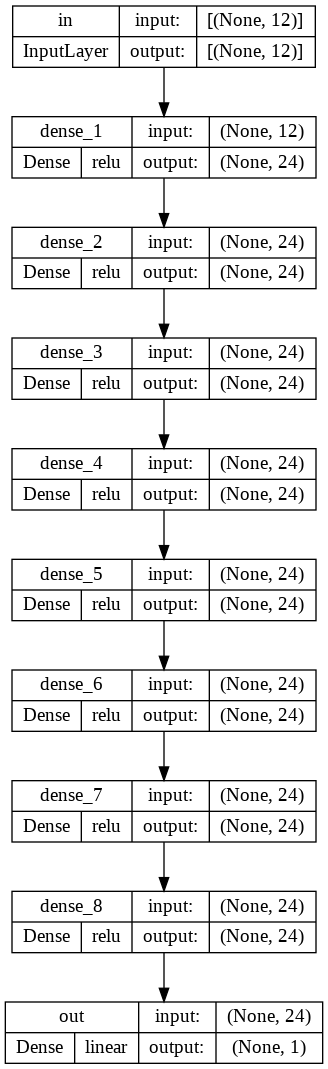

In [71]:
# Архитектура нейросети визуально
keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [72]:
#Обучение нейросети
history = model_1.fit(
  features_train, 
  target_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/50
16/16 [==============================] - 3s 27ms/step - loss: 96.3718 - root_mean_squared_error: 3.0452 - val_loss: 90.4605 - val_root_mean_squared_error: 2.8732
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 78.0737 - root_mean_squared_error: 2.5955 - val_loss: 53.0012 - val_root_mean_squared_error: 1.9245
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 36.8330 - root_mean_squared_error: 1.3313 - val_loss: 35.3361 - val_root_mean_squared_error: 1.0109
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 31.3720 - root_mean_squared_error: 1.1156 - val_loss: 32.4640 - val_root_mean_squared_error: 1.1616
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 30.0648 - root_mean_squared_error: 1.0458 - val_loss: 31.4834 - val_root_mean_squared_error: 1.0069
Epoch 6/50
16/16 [==============================] - 0s 7ms/step - loss: 29.7345 - root_mean_squared_error: 1.0469 - val_loss: 31.0660 - val

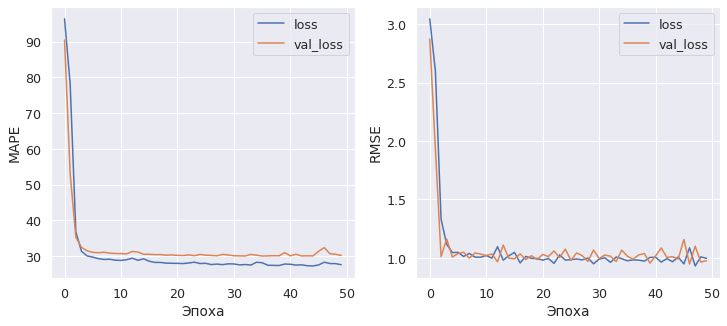

In [73]:
plot_loss(history.history)

In [74]:
# Проверяем точность нейросети на тестовых данных
model_1.evaluate(features_test, target_test)

10/10 [==============================] - 0s 3ms/step - loss: 33.5867 - root_mean_squared_error: 0.9091


[33.58674240112305, 0.909119188785553]

In [75]:
# Предсказание 
model_1_pred = model_1.predict(features_test)

10/10 [==============================] - 0s 2ms/step


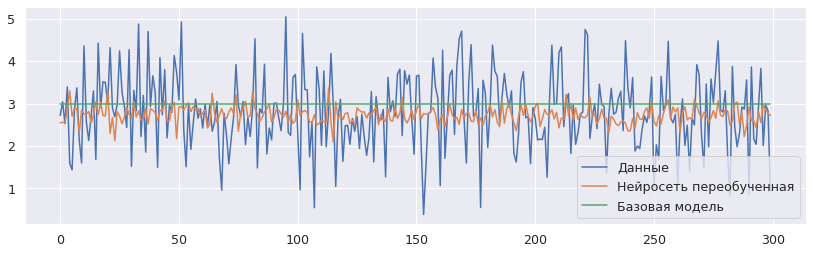

In [76]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(target_test, label='Данные')
ax.plot(model_1_pred, label='Нейросеть переобученная')
ax.plot(dummy_predictions_3, label='Базовая модель')
ax.legend()
plt.show()

Ранняя остановка процесса обучения для борьбы с переобучением

In [77]:
# Создаем модель с той же архитектурой
model_2 = construct_model()
model_2 = compile_model(model_2)

In [78]:
#Обучение нейросети
history = model_2.fit(
  features_train, 
  target_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/50
16/16 [==============================] - 2s 20ms/step - loss: 92.8747 - root_mean_squared_error: 2.9578 - val_loss: 79.8114 - val_root_mean_squared_error: 2.6096
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 54.9633 - root_mean_squared_error: 2.0059 - val_loss: 32.7895 - val_root_mean_squared_error: 0.9615
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 31.8562 - root_mean_squared_error: 1.0233 - val_loss: 31.3258 - val_root_mean_squared_error: 1.1064
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 29.3504 - root_mean_squared_error: 1.0203 - val_loss: 30.9366 - val_root_mean_squared_error: 0.9861
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 28.9325 - root_mean_squared_error: 1.0156 - val_loss: 30.9476 - val_root_mean_squared_error: 0.9706
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 28.5749 - root_mean_squared_error: 0.9888 - val_loss: 30.8413 - val

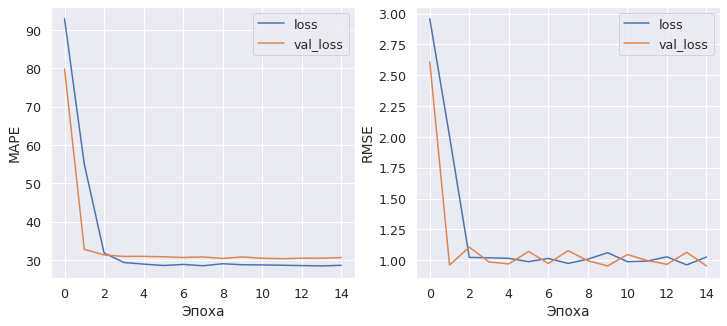

In [79]:
plot_loss(history.history)

In [80]:
# Проверяем точность нейросети на тестовых данных
model_2.evaluate(features_test, features_test)

10/10 [==============================] - 1s 2ms/step - loss: 114512752.0000 - root_mean_squared_error: 2.3196


[114512752.0, 2.319594144821167]

In [81]:
# Предсказание 
model_2_pred = model_2.predict(features_test)

10/10 [==============================] - 0s 2ms/step


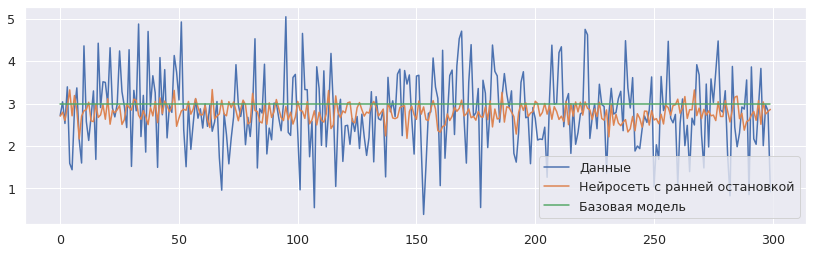

In [82]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(target_test, label='Данные')
ax.plot(model_2_pred, label='Нейросеть с ранней остановкой')
ax.plot(dummy_predictions_3, label='Базовая модель')
ax.legend()
plt.show()

Добавление Dropout-слоя

In [83]:
# Построение аналогичной модели с Dropout слоем
model_3 = tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),                   
      keras.layers.Dense(units=24, activation='relu', name='dense_1'),
      keras.layers.Dropout(0.05, name='dropout_1'),
      keras.layers.Dense(units=24, activation='relu', name='dense_2'),
      keras.layers.Dropout(0.05, name='dropout_2'),
      keras.layers.Dense(units=24, activation='relu', name='dense_3'),
      keras.layers.Dropout(0.05, name='dropout_3'),
      keras.layers.Dense(units=24, activation='relu', name='dense_4'),
      keras.layers.Dropout(0.05, name='dropout_4'),
      keras.layers.Dense(units=24, activation='relu', name='dense_5'),
      keras.layers.Dropout(0.05, name='dropout_5'),
      keras.layers.Dense(units=24, activation='relu', name='dense_6'),
      keras.layers.Dropout(0.05, name='dropout_6'),
      keras.layers.Dense(units=24, activation='relu', name='dense_7'),
      keras.layers.Dropout(0.05, name='dropout_7'),
      keras.layers.Dense(units=24, activation='relu', name='dense_8'),
      keras.layers.Dropout(0.05, name='dropout_8'),
      keras.layers.Dense(units=1, name='out')                        
    ])

In [84]:
# Компиляция модели
model_3 = compile_model(model_3)

In [85]:
# Архитектура изменилась
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 24)                312       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 24)               

In [86]:
#Обучение нейросети
history = model_3.fit(
  features_train, 
  target_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/50
16/16 [==============================] - 3s 22ms/step - loss: 98.1547 - root_mean_squared_error: 3.0874 - val_loss: 94.5806 - val_root_mean_squared_error: 2.9750
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 86.2131 - root_mean_squared_error: 2.7860 - val_loss: 68.8074 - val_root_mean_squared_error: 2.3363
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 44.6455 - root_mean_squared_error: 1.6126 - val_loss: 32.6220 - val_root_mean_squared_error: 0.9629
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 36.2734 - root_mean_squared_error: 1.2302 - val_loss: 33.9271 - val_root_mean_squared_error: 1.2806
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 32.7520 - root_mean_squared_error: 1.2023 - val_loss: 30.3661 - val_root_mean_squared_error: 1.0531
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 31.8557 - root_mean_squared_error: 1.1128 - val_loss: 31.1753 - val

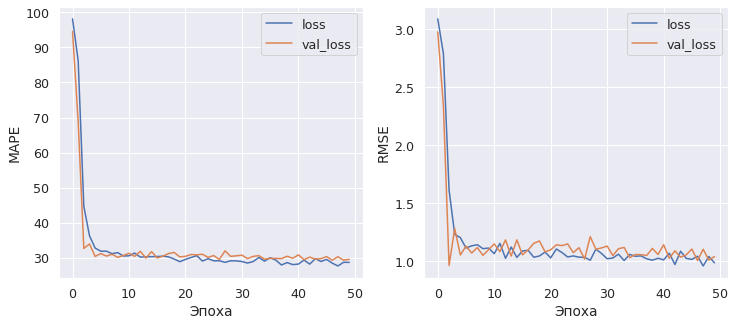

In [87]:
plot_loss(history.history)

In [88]:
# Проверяем точность нейросети на тестовых данных
model_3.evaluate(features_test, target_test)

10/10 [==============================] - 0s 2ms/step - loss: 32.6685 - root_mean_squared_error: 0.9511


[32.66849136352539, 0.9511436820030212]

In [89]:
# Предсказание 
model_3_pred = model_3.predict(features_test)

10/10 [==============================] - 0s 3ms/step


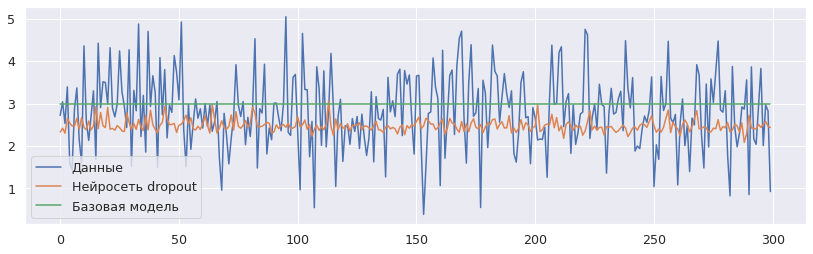

In [90]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(target_test, label='Данные')
ax.plot(model_3_pred, label='Нейросеть dropout')
ax.plot(dummy_predictions_3, label='Базовая модель')
ax.legend()
plt.show()

In [91]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
results_3 = get_metrics('DummyRegressor', target_test, dummy_predictions_3)
results_3 = results_3.append(get_metrics('Нейросеть переобученная', target_test, model_1_pred))
results_3 = results_3.append(get_metrics('Нейросеть с ранней остановкой', target_test, model_2_pred))
results_3 = results_3.append(get_metrics('Нейросеть dropout', target_test, model_3_pred))
results_3

R2      RMSE       MAE      MAPE  \
DummyRegressor                -0.042122  0.902032  0.705321  0.364728   
Нейросеть переобученная       -0.058563  0.909119  0.709295  0.335867   
Нейросеть с ранней остановкой -0.053370  0.906887  0.705222  0.340167   
Нейросеть dropout             -0.158690  0.951144  0.762612  0.326685   

                               max_error  
DummyRegressor                  2.601301  
Нейросеть переобученная         2.375639  
Нейросеть с ранней остановкой   2.532528  
Нейросеть dropout               2.604534